# Stochastic Dissipative Qubit: Single Trajectories

In [13]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh, eigvalsh, eigvals
from scipy.optimize import curve_fit
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size']=20
from scipy.linalg import expm, sqrtm
from scipy.stats import linregress
from math import acos, factorial
import matplotlib.colors as colors
from scipy.special import eval_genlaguerre, gamma, hyp1f1, erf, erfc, erfi, dawsn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
#Average results
def A(g, G):
    return G*(-1+g*G)
def B(g, G):
    return G*(-2+4*g*G)
def C(g, G):
    return -((A(g,G)+B(g,G))/3)**2 +(4+A(g,G)*B(g,G))/3
def D(g, G):
    return (A(g,G)+B(g,G))*(4+A(g,G)*B(g,G))/3 -2*B(g,G) -2*((A(g,G)+B(g,G))/3)**3
def U(m, pm, g, G):
    return (-D(g,G)/2 +pm*np.emath.sqrt((D(g,G)/2)**2+C(g, G)**3))**(1./3.)*np.exp(1j*m*2*np.pi/3)
def discriminant_cubic(g, G):
    return ((D(g,G)/2)**2+C(g, G)**3)
def eval1(g, G):
    return A(g, G)
def eval2(g, G):
    Ump = U(0, 1, g, G)
    return (Ump -C(g,G)/Ump +(A(g,G)+B(g,G))/3)
def eval3(g, G):
    Ump = U(1, 1, g, G)
    return (Ump -C(g,G)/Ump +(A(g,G)+B(g,G))/3)
def eval4(g, G):
    Ump = U(-1, 1, g, G)
    return (Ump -C(g,G)/Ump +(A(g,G)+B(g,G))/3)
def evec1(g, G):
    return np.asarray([0,1,1,0])
def evec2(g, G):
    b0 = B(g,G)-eval2(g,G)
    b1 = 1j*(B(g,G)-2*eval2(g,G))/(-A(g,G)+eval2(g,G))
    b2 = - b1
    b3 = eval2(g,G)
    return np.asarray([b0, b1, b2, b3])/B(g,G)
    """b0 = B(g,G)/B(g,G)
    b1 = -1j*eval2(g,G)/2
    b2 = - b1
    b3 = B(g,G)/B(g,G)-eval2(g,G)*(A(g,G)-eval2(g,G))/2
    return np.asarray([b0, b1, b2, b3])/(2*B(g,G)/B(g,G)-eval2(g,G)*(A(g,G)-eval2(g,G))/2)"""
def evec3(g, G):
    b0 = B(g,G)-eval3(g,G)
    b1 = 1j*(B(g,G)-2*eval3(g,G))/(-A(g,G)+eval3(g,G))
    b2 = - b1
    b3 = eval3(g,G)
    return np.asarray([b0, b1, b2, b3])/B(g,G)
def evec4(g, G):
    b0 = B(g,G)-eval4(g,G)
    b1 = 1j*(B(g,G)-2*eval4(g,G))/(-A(g,G)+eval4(g,G))
    b2 = - b1
    b3 = eval4(g,G)
    return np.asarray([b0, b1, b2, b3])/B(g,G)
def xBloch(g, G):
    λ0 = eval2(g, G)
    return np.sqrt(2)*(B(g,G)-2*λ0)/(B(g,G)*(λ0-A(g,G)))
def yBloch(g, G):
    λ0 = eval2(g, G)
    return -np.sqrt(2)*(B(g,G)-2*λ0)/(B(g,G)*(λ0-A(g,G)))
def zBloch(g, G):
    λ0 = eval2(g, G)
    return (B(g,G)-2*λ0)/(B(g,G))
def gap(g, G):
    diff_arr = np.asarray([eval2(g,G)-eval1(g, G),\
                           eval2(g,G)-np.real(eval3(g, G)),\
                           eval2(g,G)-np.real(eval4(g, G))])
    return np.min(diff_arr, axis = 0)
def maxI(g, G):
    return np.abs(np.imag(eval3(g, G)))

The SME normalized at single trajectories (no average) reads:
$$\dot \varrho = (\mathcal L[\varrho] - \text{Tr}(\mathcal L[\varrho])\varrho) dt+(\mathcal M[\varrho] - \text{Tr}(\mathcal M[\varrho])\varrho) dW_t,$$
where $\mathcal L, \mathcal M$ are two non-TP superoperators defined as
$$\mathcal L[\bullet] = - i [H_0, \bullet] -\{L, \bullet\} + \gamma \{L, \{L, \bullet\}\}$$
$$\mathcal M[\bullet] = -\sqrt{2 \gamma}\{L, \bullet\}$$
For the SDQ we take $H_0 = J \sigma_x$ and $L = (1-\sigma_z)/2$. The equations of motion for the Bloch coordinates read
$$\begin{cases}
     d x =\left( -(\gamma \Gamma_e^2 + z \Gamma_e( 1 - 2 \gamma \Gamma_e))x\right)  d t - \sqrt{2 \gamma} \Gamma_e x z  d W_t\\
     d y = \left( - 2 J z -(\gamma \Gamma_e^2 + z \Gamma_e( 1 - 2 \gamma \Gamma_e))y \right)  d t - \sqrt{2 \gamma} \Gamma_e y z  d W_t \\
     d z =   \left(2 J y - \Gamma_e (1 - 2 \gamma \Gamma_e) (z^2 - 1) \right)  d t  - \sqrt{2 \gamma} \Gamma_e (z^2 - 1)  d W_t
\end{cases}$$
Taking an initial state with $x=0$ ensures that the variable $x$ does not evolve so that the dynamics can be rreduced to $y,z$. 

In [3]:
#@numba.njit()
def detF(sol, t, γ, Γe, J):
    #out = - 2.*J - Γe*(1-2.*γ*Γe+γ*Γe*np.cos(θ))*np.sin(θ)
    #only noise
    #out =  - Γe*(-2.*γ*Γe+γ*Γe*np.cos(θ))*np.sin(θ)
    x = sol[0]
    y = sol[1]
    z = sol[2]
    out1 = np.sqrt(2)*J*z-(γ*Γe**2+z*Γe*(1-2*γ*Γe))*x
    out2 = -np.sqrt(2)*J*z-(γ*Γe**2+z*Γe*(1-2*γ*Γe))*y
    out3 = np.sqrt(2)*J*(y-x)-Γe*(1-2*γ*Γe)*(z**2-1)
    out = np.asarray([out1, out2, out3])
    return out
#@numba.njit()
def stochF(sol, t, γ, Γe, J):
    x = sol[0]
    y = sol[1]
    z = sol[2]
    out1 = -np.sqrt(2*γ)*Γe*x*z
    out2 = -np.sqrt(2*γ)*Γe*y*z
    out3 = -np.sqrt(2*γ)*Γe*(z**2-1)
    out = np.asarray([out1, out2, out3])
    return out
#@numba.njit()

Stochastic Integrator: Explicit Order 1.5 strong scheme (for autonomous 1D case) [Kloeden, PLaten book, chapt 11.2] (eqs 2.1, 2.2, 2.3 pg 378)
\begin{align}
Y_{n+1} = &Y_n + b \Delta W + \frac{a(\Upsilon_+)-a(\Upsilon_-)}{2 \sqrt{\Delta t}}\Delta Z\\
&+ \frac{a(\Upsilon_+)+ 2 a + a(\Upsilon_-)}{4}\Delta t + \frac{b(\Upsilon_+)-b(\Upsilon_-)}{4\sqrt{\Delta t} }(\Delta W^2 - \Delta t) \\
&+ \frac{b(\Upsilon_+) - 2 b + b(\Upsilon_-)}{2 \Delta t}(\Delta W \Delta t - \Delta Z)\\
&+ \frac{b(\Phi_+)-b(\Phi_-)-b(\Upsilon_+)+b(\Upsilon_-)}{4 \Delta t}\left(\frac{\Delta W^2}{3}-\Delta t\right)\Delta W,
\end{align}
where $a\equiv a(Y_n), \; b \equiv b(Y_n)$, $\Delta t$ is the time step, the auxiliary variables are
$$\Upsilon_\pm = Y_n + a \Delta t \pm b \sqrt{\Delta t}, \qquad \Phi_\pm = \Upsilon_+ \pm b(\Upsilon_+)\sqrt{\Delta t},$$ 
and the noises $\Delta W, \; \Delta Z$ are found from the transformation  (eq. 4.3 pg 352)
$$\Delta W = U_1 \sqrt{\Delta t}, \qquad \Delta Z = \frac{\Delta t^{3/2}}{2}(U_1 + \tfrac{1}{\sqrt{3}}U_2),$$
where $U_1, U_2 \sim \mathcal N(0,1)$ are i.i.d. normal random variables.

In [4]:
def StochIntegrator(y0, t_arr, pars, ξ, N_t, dt):
    #dt = t_arr[1]-t_arr[0]
    sol = np.zeros((3,N_t))
    sol[:,0] = y0
    #Kloeden-Platen explicit order 1.5 strong scheme
    for n in range(1, N_t):
        aYn = detF(sol[:,n-1], t_arr[n-1], pars[0], pars[1], pars[2])
        bYn = stochF(sol[:,n-1], t_arr[n-1], pars[0], pars[1], pars[2])
        #aux variables
        UpsP = sol[:,n-1] + aYn*dt + bYn*np.sqrt(dt)
        UpsM = sol[:,n-1] + aYn*dt - bYn*np.sqrt(dt)
        aUpsP = detF(UpsP, t_arr[n-1], pars[0], pars[1], pars[2])
        aUpsM = detF(UpsM, t_arr[n-1], pars[0], pars[1], pars[2])
        bUpsP = stochF(UpsP, t_arr[n-1], pars[0], pars[1], pars[2])
        bUpsM = stochF(UpsM, t_arr[n-1], pars[0], pars[1], pars[2])
        PhiP = UpsP + bUpsP*np.sqrt(dt)
        PhiM = UpsP - bUpsP*np.sqrt(dt)
        bPhiP = stochF(PhiP, t_arr[n-1], pars[0], pars[1], pars[2])
        bPhiM = stochF(PhiM, t_arr[n-1], pars[0], pars[1], pars[2])
        #Random variables 
        U1 = ξ[n,0]
        U2 = ξ[n,1]
        ΔW = U1*np.sqrt(dt)
        ΔZ = dt**(3/2)/2*(U1+U2/np.sqrt(3))
        #solution
        sol[:,n] = sol[:,n-1] + bYn*ΔW + (aUpsP - aUpsM)*ΔZ/(2*np.sqrt(dt))\
        + (aUpsP + 2*aYn + aUpsM)*dt/4 + (bUpsP - bUpsM)*(ΔW**2 - dt)/(4*np.sqrt(dt))\
        + (bUpsP - 2*bYn + bUpsM)*(ΔW*dt - ΔZ)/(2*dt)\
        + (bPhiP - bPhiM - bUpsP + bUpsM)*(ΔW**2/3 - dt)*ΔW/(4*dt)
    #RK2
    """for n in range(1, N_t):
        aYn = detF(sol[n-1], 0, pars[0], pars[1], pars[2])
        bYn = stochF(sol[n-1], 0, pars[0], pars[1], pars[2])
        #ΔWn = np.random.normal(0, dt)
        ΔWn = ξ[n]
        varYn = sol[n-1] + aYn*dt + bYn*np.sqrt(dt)
        bvarYn = stochF(varYn, 0, pars[0], pars[1], pars[2])
        sol[n] = sol[n-1] + aYn*dt + bYn*ΔWn +0.5*(bvarYn-bYn)*(ΔWn**2-dt)*dt**(-0.5)"""
    #Euler  Maruyama
    """for n in range(1, len(t_arr)):
        aYn = detF(sol[n-1], t_arr[n-1], pars[0], pars[1], pars[2])
        bYn = stochF(sol[n-1], t_arr[n-1], pars[0], pars[1], pars[2])
        ΔWn = np.random.normal(0, np.sqrt(dt))
        sol[n] = sol[n-1] + aYn*dt + bYn*ΔWn"""
    #Rossler
    #for n in range(1, len(t_arr))
    return sol
def tildeSRE_av(g, G):
    l0 = eval2(g, G)
    a = A(g, G)
    numer = (16*l0**4 + (a - l0)**4*l0**4 + (4 - a*l0 + l0**2)**4)/((4 - a*l0 + l0**2)**2*(16 + 2*l0*(6*l0 + a**2*l0 + l0**3 - 2*a*(2 + l0**2))))
    ry = yBloch(g,G)
    rz = zBloch(g,G)
    L = np.abs(ry) + np.abs(rz)
    if L>1:
        return -np.log(numer)/np.log(2)
    else:
        return 0
def tildeSRE_st(x, y,z):
    #print(y)
    """out = np.zeros(len(y))
    L = np.abs(y) + np.abs(z)
    aux_log = (1**4 + y**4 + z**4)/(1 + y**2+z**2)
    cond_nonStab = np.where(L>1)
    out[cond_nonStab] = -np.log(aux_log[cond_nonStab])/np.log(2)"""
    aux_log = (1**4 + x**4 + y**4 + z**4)/(1 + x**2 +y**2+z**2)
    out = -np.log(aux_log)/np.log(2)
    return out

In [5]:
def compute_trajs(y0, t_arr, pars, Nav, N_t):
    out_trajs = np.zeros((3,N_t, Nav))
    out_trajs_SRE = np.zeros((N_t, Nav))
    dt = t_arr[1] - t_arr[0]
    for k in range(Nav):
        ξ = np.random.randn(N_t, 2)
        out_trajs[:,:,k] = StochIntegrator(y0, t_arr, pars, ξ, N_t, dt)
        out_trajs_SRE[:,k] = tildeSRE_st(out_trajs[0,:,k], out_trajs[1,:,k], out_trajs[2,:,k])
    return out_trajs, out_trajs_SRE
def fx(x, y, z, G, g, t):
    return (-(g*G**2+ z*G*(1-2*G*g))*x/2)*2
def fy(x, y, z, G, g, t):
    return (-z-(g*G**2+ z*G*(1-2*G*g))*y/2)*2
def fz(x, y, z, G, g, t):
    return (y-G*(1-2*g*G)*(z**2-1)/2)*2
def F(r, t, G, g):
    return np.asarray([fx(r[0], r[1], r[2], G, g, t), \
                       fy(r[0], r[1], r[2], G, g, t), \
                       fz(r[0], r[1], r[2], G, g, t)])
def RK4_integrator(rn, tn, dt, G, g):
    k1 = F(rn, tn, G, g)
    k2 = F(rn+dt*k1/2, tn+dt/2, G, g)
    k3 = F(rn+dt*k2/2, tn+dt/2, G, g)
    k4 = F(rn+dt*k3, tn+dt, G, g)
    rnp1 = rn + dt/6*(k1+2*k2+2*k3+k4)
    return rnp1
def compute_trajs_av(r0, t_arr, N_t, G, g):
    r_arr = np.zeros((3, N_t))
    dt = t_arr[1] - t_arr[0]
    r_arr[:,0] = r0
    for n in range(1, N_t):
        r_arr[:, n] = RK4_integrator(r_arr[:,n-1], t_arr[n-1], dt, G, g)
    return r_arr

In [6]:
#single set of parameters
γ = 0.01
Γe = np.sqrt(6)
J = 1
pars = np.asarray([γ, Γe, J])
N_t = 500
tdiss = 1/gap(γ*J, Γe/J)
tf = 4*tdiss
t_arr2 = np.linspace(0, tf, N_t)
#print(t_arr[1])
N_av = 1000
#θ_0 = 0.9438
x0_arr = np.asarray([0])
y0_arr = np.asarray([0])
z0_arr = np.asarray([0])
sol0_arr = np.asarray([x0_arr, y0_arr, z0_arr])
#print(sol0_arr[:,0])
trajs = np.zeros((3, N_t, N_av, len(z0_arr)))
tilde_SRE_trajs = np.zeros((N_t, N_av, len(z0_arr)))
avg_x = np.zeros((N_t, len(z0_arr)))
avg_y = np.zeros((N_t, len(z0_arr)))
avg_z = np.zeros((N_t, len(z0_arr)))
#std_z = np.zeros((N_t, len(z0_arr)))
#std_y = np.zeros((N_t, len(z0_arr)))
for n in range(len(z0_arr)):
    trajs[:,:,:,n], tilde_SRE_trajs[:,:,n] = compute_trajs(sol0_arr[:,n], t_arr2, pars, N_av, N_t)
    avg_x[:,n] = np.average(trajs[0,:,:,n], axis = 1)
    avg_y[:,n] = np.average(trajs[1,:,:,n], axis = 1)
    avg_z[:,n] = np.average(trajs[2,:,:,n], axis = 1)
    #tilde_SRE_trajs[:,n] = tildeSRE_st(avg_y[:,n], avg_z[:,n])
#trajs = compute_trajs(θ_0, t_arr2, pars, N_av, N_t)

<ipython-input-4-bcffb9b90623>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  sol[:,n] = sol[:,n-1] + bYn*ΔW + (aUpsP - aUpsM)*ΔZ/(2*np.sqrt(dt))\


In [7]:
"""#print(trajs)
#plt.figure()
fig, axs = plt.subplots(2,1,sharex = True, sharey = True, figsize = [5,4])
plt.subplots_adjust(hspace = 0.)
for n in range(N_av):
    axs[0].plot(t_arr2, np.cos(trajs[:,n, 0]), c = 'gray', lw = .5, zorder = 0)
    axs[1].plot(t_arr2, np.sin(trajs[:,n, 0]), c = 'gray', lw = .5, zorder = 0)
#plt.ylim(0.986, 1)
axs[0].plot(t_arr2, avg_z, c = 'b', lw = 2)
axs[0].plot(t_arr2, avg_z-std_z, c = 'b', lw = 0.5, ls = '--')
axs[0].plot(t_arr2, avg_z+std_z, c = 'b', lw = 0.5, ls = '--')
#axs[0].fill_between(t_arr2, avg_z-std_z, avg_z+std_z, color = 'b', alpha = 0.2)
axs[1].plot(t_arr2, avg_y, c = 'b', lw = 2)
axs[1].plot(t_arr2, avg_y-std_y, c = 'b', lw = 0.5, ls = '--')
axs[1].plot(t_arr2, avg_y+std_y, c = 'b', lw = 0.5, ls = '--')
#axs[1].fill_between(t_arr2, avg_y-std_y, avg_y+std_y, color = 'b', alpha = 0.2)
axs[0].set_ylabel("$z(t)$")
axs[1].set_ylabel("$y(t)$")
axs[1].set_xlabel("$t$")
plt.xlim(t_arr2[0], t_arr2[-1])
#axs[1].set_xscale('log')
axs[0].set_title(r"$\gamma="+str(γ)+",\; \Gamma_e ="+str(Γe)+",\; J="+str(J)+"$")
#plt.savefig("SDQ_single_trajs_NI_KP.pdf", bbox_inches = 'tight')
plt.show()
"""

'#print(trajs)\n#plt.figure()\nfig, axs = plt.subplots(2,1,sharex = True, sharey = True, figsize = [5,4])\nplt.subplots_adjust(hspace = 0.)\nfor n in range(N_av):\n    axs[0].plot(t_arr2, np.cos(trajs[:,n, 0]), c = \'gray\', lw = .5, zorder = 0)\n    axs[1].plot(t_arr2, np.sin(trajs[:,n, 0]), c = \'gray\', lw = .5, zorder = 0)\n#plt.ylim(0.986, 1)\naxs[0].plot(t_arr2, avg_z, c = \'b\', lw = 2)\naxs[0].plot(t_arr2, avg_z-std_z, c = \'b\', lw = 0.5, ls = \'--\')\naxs[0].plot(t_arr2, avg_z+std_z, c = \'b\', lw = 0.5, ls = \'--\')\n#axs[0].fill_between(t_arr2, avg_z-std_z, avg_z+std_z, color = \'b\', alpha = 0.2)\naxs[1].plot(t_arr2, avg_y, c = \'b\', lw = 2)\naxs[1].plot(t_arr2, avg_y-std_y, c = \'b\', lw = 0.5, ls = \'--\')\naxs[1].plot(t_arr2, avg_y+std_y, c = \'b\', lw = 0.5, ls = \'--\')\n#axs[1].fill_between(t_arr2, avg_y-std_y, avg_y+std_y, color = \'b\', alpha = 0.2)\naxs[0].set_ylabel("$z(t)$")\naxs[1].set_ylabel("$y(t)$")\naxs[1].set_xlabel("$t$")\nplt.xlim(t_arr2[0], t_arr2[-1])

/Users/pablo.martinez/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/pablo.martinez/opt/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py:2868: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/Users/pablo.martinez/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:3374: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


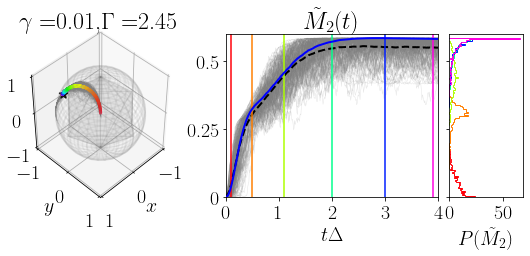

In [19]:
#fig, axs = plt.subplots(1,2, figsize = [8,3])
fig = plt.figure(figsize = [8,3])
#cm = plt.get_cmap("Blues_r")
#cm = colors.LinearSegmentedColormap.from_list("", ["midnightblue","blue", "lightskyblue"])
cm = plt.get_cmap("gist_rainbow")
N_trajs_show = int(N_av/5)
plt.subplots_adjust(wspace = 0.1)
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
for n in range(len(z0_arr)):
    for k in range(N_trajs_show):
        ax0.plot(trajs[0,:,k,n], trajs[1,:,k,n], trajs[2,:,k,n], c = 'gray', lw = 0.5, alpha = 0.2)
    #p1=axs[0].plot(avg_y[:,n], avg_z[:,n], c = 'k', marker = '', lw = 2)
    p1=ax0.scatter3D(avg_x[:,n],avg_y[:,n], avg_z[:,n], c = np.real(t_arr2/tdiss), marker = '.', zorder = 0, cmap = cm)
#plt.fill_between(avg_y-std_y, )
ax0.set_xlim(-1, 1)
ax0.set_ylim(-1,1)
#ax0.plot([-1,0,1,0,-1],[0,1,0,-1,0], c = 'k', lw = .5, zorder = 20 )
A_oct = [1, 0, 0]
B_oct = [0, 1, 0]
C_oct = [0, 0, 1]
D_oct = [-1, 0, 0]
E_oct = [0, -1, 0]
F_oct = [0, 0, -1]
#aux = np.asarray([A_oct, B_oct, C_oct, D_oct, E_oct, F_oct])
OCTO = [[E_oct, A_oct, B_oct],
        [E_oct, B_oct, D_oct],
        [E_oct, D_oct, C_oct],
        [E_oct, C_oct, A_oct],
        [F_oct, A_oct, B_oct],
        [F_oct, B_oct, D_oct],
        [F_oct, D_oct, C_oct],
        [F_oct, C_oct, A_oct],
]
ax0.add_collection3d (Poly3DCollection (OCTO, alpha = .1, color = 'gray'))
#OCTO = np.asarray(OCTO)
#ax0.plot(OCTO[:,0], OCTO[:,1], OCTO[:,2])
# sphere
u = np.linspace (0, np.pi, 30)
v = np.linspace (0, 2 * np.pi, 30)
x = np.outer (np.sin (u), np.sin (v))
y = np.outer (np.sin (u), np.cos (v))
z = np.outer (np.cos (u), np.ones_like (v))
ax0.plot_wireframe (x, y, z, alpha = 0.1, color = 'gray')
ax0.set_aspect("equal")
ax0.view_init(45, 45)
x_st = np.real(xBloch(γ*J, Γe/J))
y_st = np.real(yBloch(γ*J, Γe/J))
z_st = np.real(zBloch(γ*J, Γe/J))
#ax0.scatter3D(x_st, y_st, z_st)
ax0.scatter3D(x_st, y_st, z_st, marker = '*', zorder = 100, c = 'k', linewidths = 1.5, s = 70)
#x = np.linspace(-np.pi, np.pi, 100)
#SDMstd = np.sqrt(1-y_st**2-z_st**2)/2
#ax0.plot(y_st+SDMstd*np.sin(x), z_st+SDMstd*np.cos(x))
ax1 = fig.add_subplot(1, 2, 2)
for n in range(len(z0_arr)):
    for k in range(N_trajs_show):
        ax1.plot(t_arr2/tdiss, tilde_SRE_trajs[:, k,n], lw = 0.5, alpha = 0.2, c = 'gray')
    ax1.plot(t_arr2/tdiss, np.average(tilde_SRE_trajs[:, :,n], axis = 1), lw = 2, c = 'k', ls ='--')
    ax1.plot(t_arr2/tdiss,  tildeSRE_st(avg_x[:,n], avg_y[:,n], avg_z[:,n]), c ='b', lw = 2, zorder =20)
    #axs[1].scatter(t_arr2/tdiss,  tildeSRE_st(avg_y[:,n], avg_z[:,n]), c =t_arr2/tdiss, marker = '.', cmap = cm, zorder =20)
#axs[1].plot(t_arr2/tdiss, np.average(tilde_SRE_trajs, axis = 1), c= 'k', lw = 3)
#plt.savefig()
ax1.set_xlim(t_arr2[0], t_arr2[-1]/tdiss)
ax1.set_title(r"$\tilde M_2(t)$")
ax1.set_xlabel(r"$t \Delta$")
ax0.set_xlabel(r"$x$")
ax0.set_ylabel(r"$y$")
ax0.set_zlabel(r"$z$")
ax0.set_zlim(-1,1)
ax0.set_title(r"$\gamma =$"+str(np.round(γ,3))+r",$\Gamma =$"+str(np.round(Γe,2)))
"""divider3 = make_axes_locatable(axs[0])
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(p1, cax = cax3)
cb.ax.set_title(r"$t\Delta $")"""
#cb.set_label(r"$t\Delta $")
#axs[1].set_yscale('log')
#axs[1].set_xscale('log')
ax1.set_xlim(t_arr2[1]/tdiss, t_arr2[-1]/tdiss)
ax1.set_ylim(0,)
ax1.set_yticks([0, 0.25, 0.5])
ax1.set_xticks([0,1,2,3, 4])
ax2 = ax1.inset_axes([1.05, 0, 0.35, 1], sharey=ax1)
#ax2.get_yticklabels(visible=False)
#ax2.tick_params('y', labelbottom=False)
#tDelta_show = np.asarray([0.1, 0.3,0.5, 1.1, 2, 3, 3.9])
tDelta_show = np.asarray([0.1,0.5, 1.1, 2, 3, 3.9])
ax2.set_yticklabels([0, 0.25, 0.5],visible = False)
ax2.set_xlabel(r"$P(\tilde M_2)$")
ax1.set_ylim(0, 0.6)
#ax2.set_xscale('log')
for n in range(len(tDelta_show)):
    idx = np.argmin(np.abs(t_arr2/tdiss-tDelta_show[n]))
    ax1.vlines(t_arr2[idx]/tdiss, 0, 0.6, color = cm(idx/len(t_arr2)))
    ax2.hist(tilde_SRE_trajs[idx, :, 0], 50, density = True, histtype='step', color = cm(idx/len(t_arr2)), orientation='horizontal')
#plt.savefig("SDQ_ST_evolM2_NI6_diffPsi0.pdf", bbox_inches = 'tight' )
plt.savefig("SDQxy_ST_evolM2_PTb.pdf", bbox_inches = 'tight' )
plt.show()

In [10]:
#np.save(trajs, "trajs_SDQ_xy_g_"+str(γ)+"_G_"+str(Γe)+".npy")

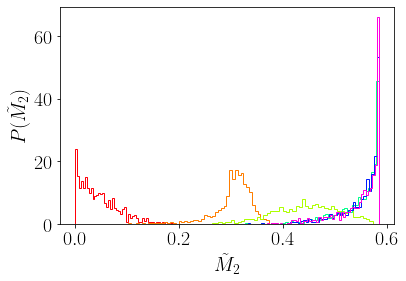

In [20]:
plt.figure()
#tDelta_show = np.asarray([0.1,0.3, 0.5, 1, 2, 3, 4])
#cmap = plt.get_cmap("viridis")
for n in range(len(tDelta_show)):
    idx = np.argmin(np.abs(t_arr2/tdiss-tDelta_show[n]))
    plt.hist(tilde_SRE_trajs[idx, :, 0], 50, density = True, histtype='step', color = cm(idx/len(t_arr2)))
#plt.hist(tilde_SRE_trajs[-1, :, 0], 50, density = True, histtype='step')
#plt.yscale('log')
#plt.ylim(5e-1,)
plt.xlabel(r"$\tilde M_2$")
plt.ylabel(r"$P(\tilde M_2)$")
plt.savefig("SDQ_hist_SRE_NI.pdf", bbox_inches = 'tight')
plt.show()